## Logistic Regression 기반 질병 유무 예측 모델링 

*

In [94]:
# General Library
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ml
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.preprocessing import MinMaxScaler


# 한글 오류 해결
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [157]:
# Data import
df = pd.read_csv('heart.csv')

# check df
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [12]:
# check data size
print("전체 column의 개수 :%d" %df.shape[1])
print("전체 row의 개수 :%d" %df.shape[0])

전체 column의 개수 :14
전체 row의 개수 :303


In [14]:
# check missing value
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

![컬럼명세](https://user-images.githubusercontent.com/35517797/70862044-38f0d580-1f7a-11ea-9234-54bd8644794c.PNG)

In [100]:
# numeric & category

numeric = ['age','trestbps','chol','thalach','oldpeak','ca']
category = ['sex','cp','fbs','restecg','exang','thal','slope']

<br>

### Exploratory Data Analysis

<br>

In [ ]:
# 가설
# 위험요인 예방요인

In [35]:
# visualization module

# numeric  //  distribution
def vis_distribution(feature,title):
    
    plt.figure(figsize=(8,6))

    sns.distplot(df[df.target == 1]['age'],label='1')
    sns.distplot(df[df.target == 0]['age'],label='0')

    plt.legend()
    plt.title('심장병 유무별 나이대 분포')
    
    return plt


# category  //  barchart
def vis_barchart(feature,legend):
    yes_heart = df[df.target == 1][feature].value_counts()
    no_heart = df[df.target == 0][feature].value_counts()  
    plt_df = pd.DataFrame([yes_heart,no_heart])
    plt_df.index = ['yes_heart','no_heart']
    
    plt_df.plot(kind='bar',stacked=True,figsize=(12,6)).legend(legend,title=(feature))
    
    return plt_df

<br>

### Feature Engineering

<br>

In [158]:
# category => dummies

def get_dummies(feature):
    
    global df
    
    t_list = []
    for i in feature:
        t = pd.get_dummies(df[i],prefix=i)
        t_list.append(t)
        
    result_df = df[numeric].join(t_list)
    result_df['target'] = df['target']
    result_df.drop('sex_0',axis=1,inplace=True)
    result_df.drop('fbs_0',axis=1,inplace=True)
    result_df.drop('exang_0',axis=1,inplace=True)
    result_df.drop('slope_0',axis=1,inplace=True)
    
    return result_df

In [159]:
# get_dummies

dummy_list = category

result_df = get_dummies(dummy_list)

In [160]:
## ca feature 

result_df['ca'] = np.where(result_df['ca']==0,0,1)

In [161]:
sc_age = MinMaxScaler()
sc_trestbps = MinMaxScaler()
sc_chol = MinMaxScaler()
sc_thalach = MinMaxScaler()
sc_oldpeak = MinMaxScaler()

scaled_age = sc_age.fit_transform(result_df[['age']])
scaled_trestbps = sc_trestbps.fit_transform(result_df[['trestbps']])
scaled_chol = sc_chol.fit_transform(result_df[['chol']])
scaled_thalach = sc_thalach.fit_transform(result_df[['thalach']])
scaled_oldpeak = sc_oldpeak.fit_transform(result_df[['oldpeak']])

total = np.concatenate((scaled_age, scaled_trestbps), axis=1)
total = np.concatenate((total, scaled_chol), axis=1)
total = np.concatenate((total, scaled_thalach), axis=1)
total = np.concatenate((total, scaled_oldpeak), axis=1)

total = pd.DataFrame(total, columns=['age','trestbps','chol','thalach','oldpeak'],index=result_df.index)
result_df = total.join(result_df.iloc[:,5:])

In [162]:
result_df.iloc[:,:-1].columns

Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'sex_1', 'cp_0',
       'cp_1', 'cp_2', 'cp_3', 'fbs_1', 'restecg_0', 'restecg_1', 'restecg_2',
       'exang_1', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'slope_1',
       'slope_2'],
      dtype='object')

Optimal number of features: 12
Selected features: ['trestbps', 'thalach', 'oldpeak', 'ca', 'sex_1', 'cp_0', 'cp_2', 'cp_3', 'exang_1', 'thal_2', 'thal_3', 'slope_2']


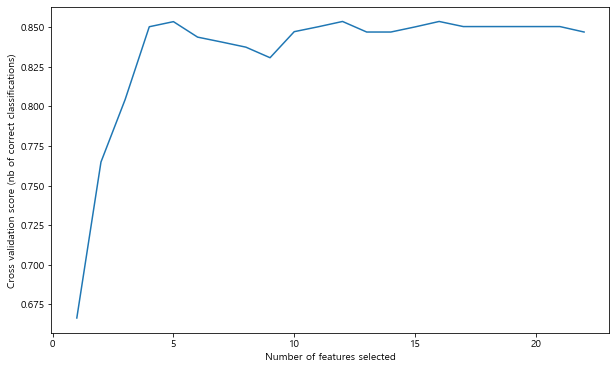

In [164]:
# search optimal parameter

X = result_df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'sex_1', 'cp_0',
       'cp_1', 'cp_2', 'cp_3', 'fbs_1', 'restecg_0', 'restecg_1', 'restecg_2',
       'exang_1', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'slope_1',
       'slope_2']]
y = result_df['target']

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

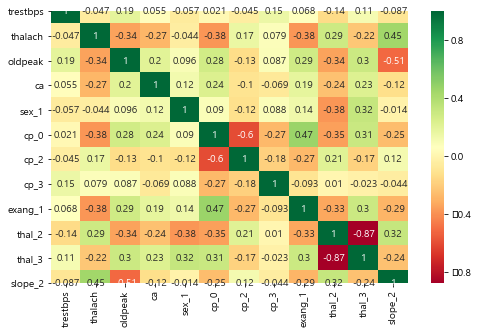

In [165]:
Selected_features = ['trestbps', 'thalach', 'oldpeak', 'ca', 'sex_1', 'cp_0', 'cp_2', 
                     'cp_3', 'exang_1', 'thal_2', 'thal_3', 'slope_2']

X = result_df[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

In [166]:
# split train / test

dependent_variable = result_df['target']
independent_variables = result_df[Selected_features]
x_train, x_test, y_train, y_test = train_test_split(independent_variables, dependent_variable, test_size=0.2, random_state=0)

In [167]:
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)

print('학습용 데이터셋 정확도 : %.2f' % lr_model.score(x_train, y_train))
print('검증용 데이터셋 정확도 : %.2f' % lr_model.score(x_test, y_test))

학습용 데이터셋 정확도 : 0.87
검증용 데이터셋 정확도 : 0.85


In [168]:
independent_variables_with_constant = sm.add_constant(independent_variables,prepend=True) ##

sm_result = sm.Logit(dependent_variable, independent_variables_with_constant).fit()
sm_result.summary()

Optimization terminated successfully.
         Current function value: 0.316431
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  303
Model:                          Logit   Df Residuals:                      290
Method:                           MLE   Df Model:                           12
Date:                Thu, 19 Dec 2019   Pseudo R-squ.:                  0.5409
Time:                        03:37:38   Log-Likelihood:                -95.879
converged:                       True   LL-Null:                       -208.82
Covariance Type:            nonrobust   LLR p-value:                 1.429e-41
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8660      1.293      2.217      0.027       0.332       5.400
trestbps      -2.2937      1.130     -2.030      0.042      -4.508      -0.079
thalach        1.7245      1.333      1.294      0.196      -0.888       4.337
oldpeak       -2.9538      1.348     -2.191      0.028      -5.596      -0.311
ca            -2.2467      0.414     -5.423      0.000      -3.059      -1.435
sex_1         -1.4335      0.505     -2.841      0.004      -2.422      -0.445
cp_0          -1.1261      0.572     -1.968      0.049      -2.248      -0.004
cp_2           1.0634      0.633      1.680      0.093      -0.177       2.304
cp_3           1.1289      0.780      1.448      0.148      -0.399       2.657
exang_1       -0.7481      0.431     -1.738      0.082      -1.592       0.096
thal_2        -0.1281      0.745     -0.172      0.863      -1.588       1.332
thal_3        -1.4717      0.725     -2.030      0.042      -2.893      -0.050
slope_2        1.1572      0.457      2.533      0.011       0.262       2.053
==============================================================================
"""

In [169]:
# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
y_pred_proba = logreg.predict_proba(x_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 0.852
LogisticRegression log_loss is 0.338
LogisticRegression auc is 0.932


In [170]:
logreg = LogisticRegression()
# Use cross_val_score function
# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
# cv=10 for 10 folds
# scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} for evaluation metric - althought they are many
scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.850
LogisticRegression average log_loss is 0.355
LogisticRegression average auc is 0.927
